# Series Registration

In [1]:
import numpy as np
import torch
import cv2
import kornia as K
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple

from utils import convert_image_to_tensor, convert_img_tensor_to_numpy, match_sizes_resize, match_sizes_resize_batch
# from masking import keypoints_roi_to_image, scale_image, mask_leaf, erode_crop_leaf, crop_ROI_erode_leaf, 
from masking import fetch_full_leaf, fetch_rotated_ROI, fetch_unrotated_ROI, fetch_image_mask_pair, fetch_registered_image_mask_pair
from loftr import loftr_match, tps_skimage, register_loftr_tps, warp_tps
from plotting import plot_image_pair, plot_overlay, plot_matches, plot_matches_conf, plot_match_coverage
from DatasetTools.LeafImageSeries import LeafDataset

In [10]:
leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    # leaf_uid="ESWW0070020_1",
    leaf_uid="ESWW0070023_6", # has much missing data 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('target_images', 'target_masks', 'leaf_masks', 'seg_masks', 'det_masks', 'cropped_images', 'rois', 'images', 'keypoints', 'roi_leaf_masks'),
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...
Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading images...
Loading cropped images...
Loading ROIs...
Loading Target Masks...
Loading Leaf Masks...
Loading Detection Masks...
Loading Segmentation Masks...
Generating Symptom Masks...


Processing series: 100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


Generating ROI Leaf Masks...


Processing series:  27%|██▋       | 4/15 [00:03<00:08,  1.28it/s]

No ROI data for index 4


Processing series: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Loading target images...
Loading keypoints...


## Problem Cases

In [2]:
moving_ind = 13

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070020_2", 
    load=('roi_leaf_masks'),
    verbose=False
)

Processing series: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


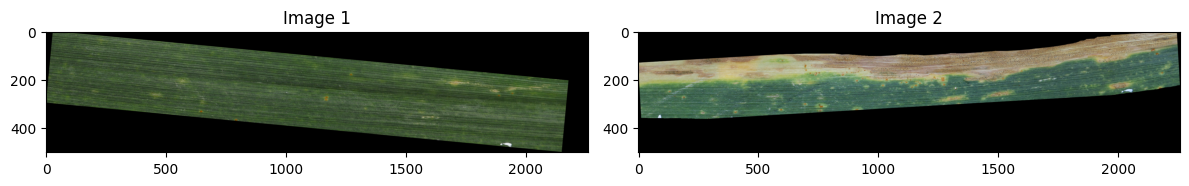

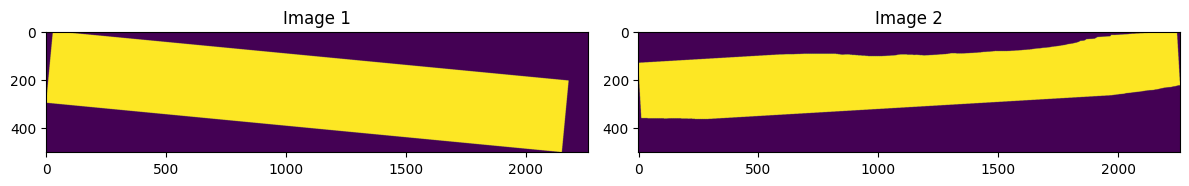

In [ ]:
img_fixed, mask_fixed = fetch_image_mask_pair(leaf, 0, img_scale="roi", erase_markers=True, pre_rotate=False)
img_moving, mask_moving = fetch_image_mask_pair(leaf, moving_ind, img_scale="roi", erase_markers=True, pre_rotate=False)
img_fixed, img_moving, mask_fixed, mask_moving = match_sizes_resize(img_fixed, img_moving, mask_fixed, mask_moving)
_ = plot_image_pair(img_fixed, img_moving)
_ = plot_image_pair(mask_fixed, mask_moving)

Total matches: 648
Matches with Confidence > 0.5: 253
Inliers: 307 (47.38%)
Threshold set to 0.5
Estimating TPS transform...
Transforming moving image...
Transforming moving image...


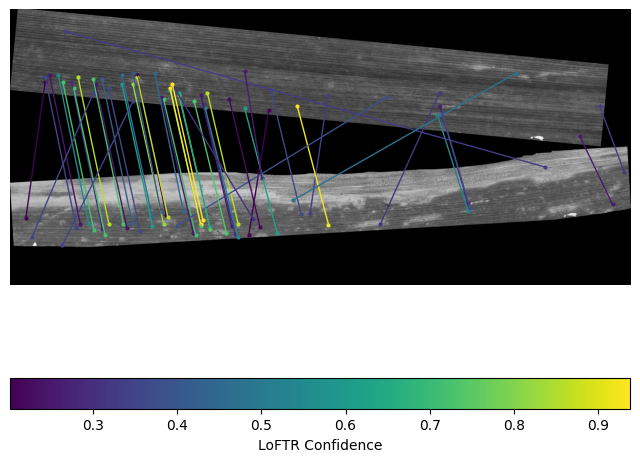

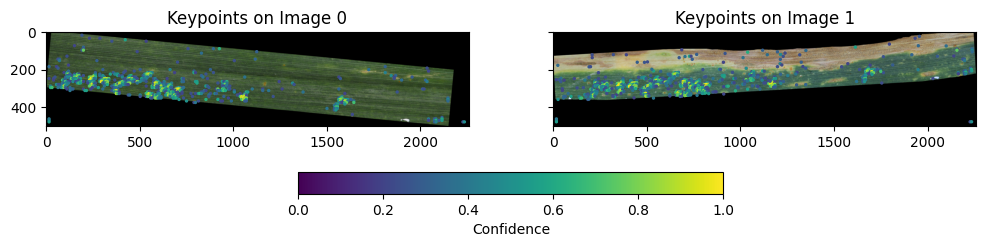

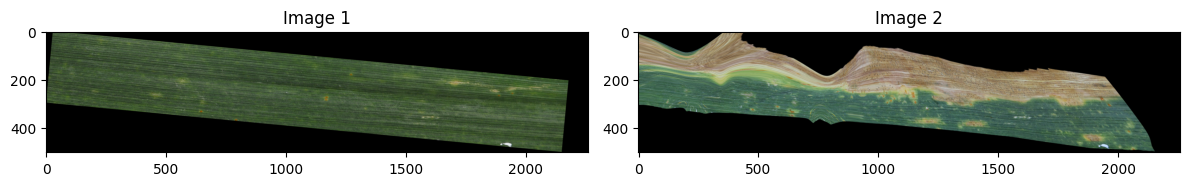

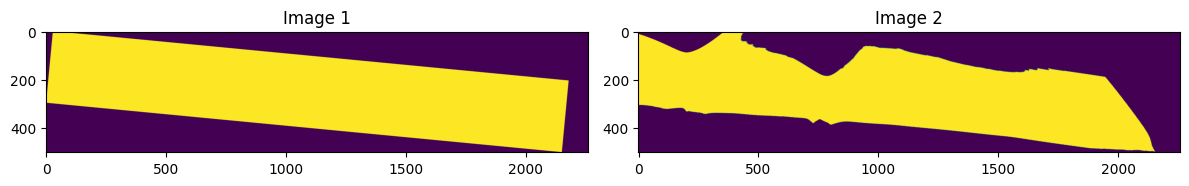

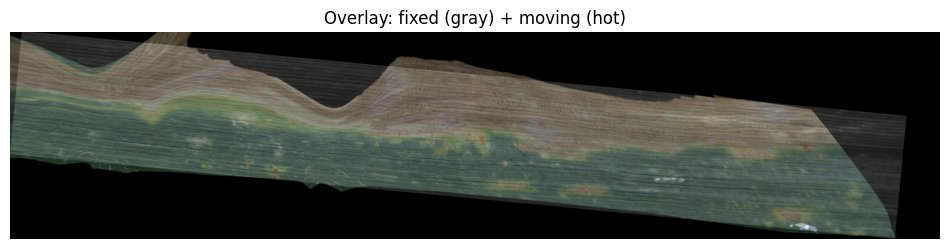

In [13]:
warped_moving_img, warped_moving_mask = register_loftr_tps(img_fixed, img_moving, mask_moving=mask_moving, threshold=0.5, verbose=True, plot_loftr_matches=True, return_tps=False)
_ = plot_image_pair(img_fixed, warped_moving_img)
_ = plot_image_pair(mask_fixed, warped_moving_mask)
_ = plot_overlay(img_fixed, warped_moving_img)

Total matches: 648
Matches with Confidence > 0.5: 253
Inliers: 307 (47.38%)
Threshold set to 0.3
Estimating TPS transform...
Transforming moving image...
Transforming moving image...


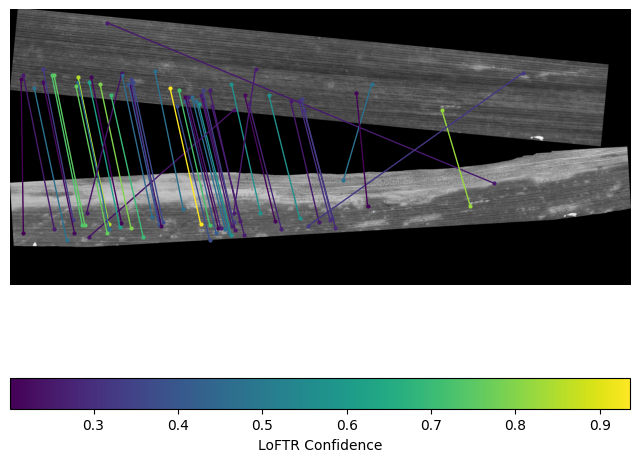

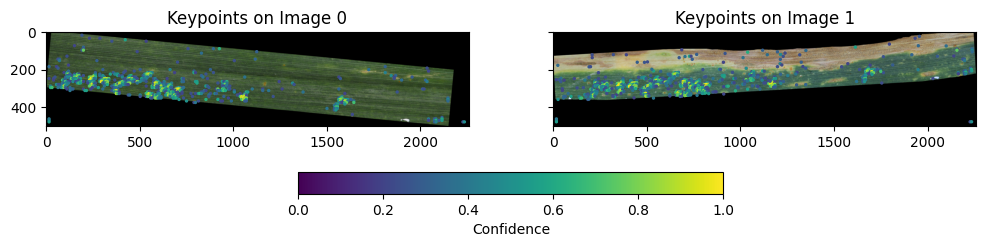

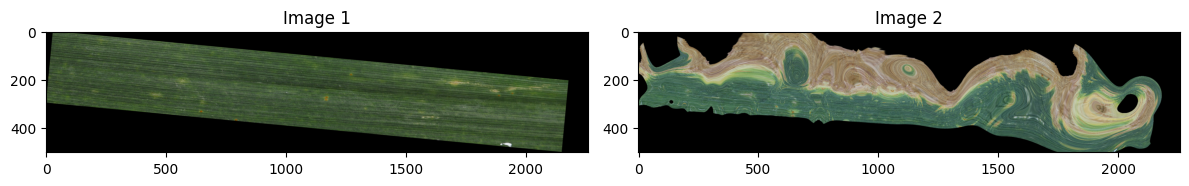

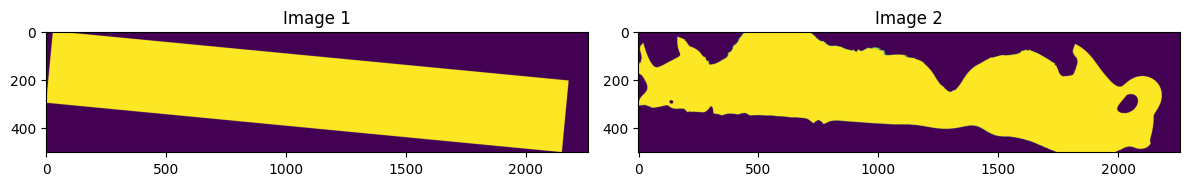

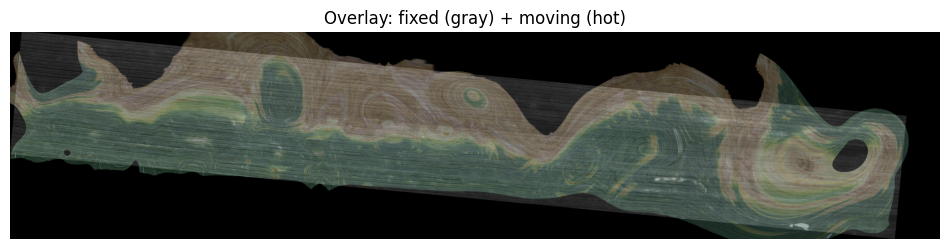

In [54]:
# lower base threshold
warped_moving_img, warped_moving_mask = register_loftr_tps(img_fixed, img_moving, mask_moving=mask_moving, threshold=0.3, verbose=True, plot_loftr_matches=True, return_tps=False)
_ = plot_image_pair(img_fixed, warped_moving_img)
_ = plot_image_pair(mask_fixed, warped_moving_mask)
_ = plot_overlay(img_fixed, warped_moving_img)

=> lowering threshold is a bad idea

## Individual

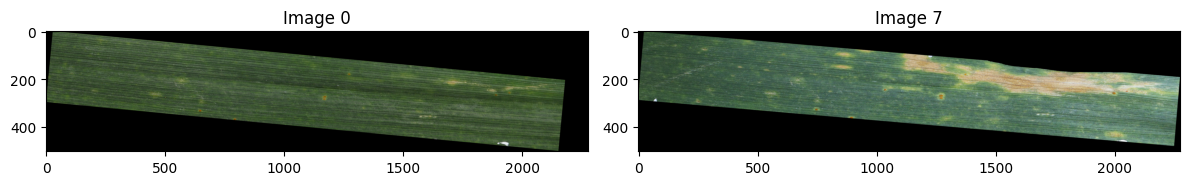

In [3]:
i = 7
img_fixed_og, mask_fixed_og = fetch_image_mask_pair(leaf, 0, img_scale="roi")
img_moving_og, mask_moving_og = fetch_image_mask_pair(leaf, i, img_scale="roi")
img_fixed, img_moving, mask_fixed, mask_moving = match_sizes_resize(img_fixed_og, img_moving_og, mask_fixed_og, mask_moving_og)
_ = plot_image_pair(img_fixed, img_moving, 0 ,i)

In [13]:
def register_leaf_seq(leaf: LeafDataset, img_scale: str="full", pre_rotate: bool=False, erase_markers: bool=True, return_masks: bool=True, use_scaling_erosion: bool=False):
    img_fixed_og, mask_fixed_og = fetch_image_mask_pair(leaf, 0, img_scale=img_scale, pre_rotate=pre_rotate, erase_markers=erase_markers, use_scaling_erosion=use_scaling_erosion)

    registered_imgs = [img_fixed_og]
    if return_masks:
        masks = [mask_fixed_og]
    
    moving_indices = np.arange(1, leaf.n_leaves)
    for ind in tqdm(moving_indices):
        img_moving, mask_moving = fetch_image_mask_pair(leaf, ind, img_scale=img_scale, pre_rotate=pre_rotate, erase_markers=erase_markers, use_scaling_erosion=use_scaling_erosion)

        # resize
        img_fixed, img_moving, mask_fixed, mask_moving = match_sizes_resize(img_fixed_og, img_moving, mask_fixed_og, mask_moving)

        # register
        img_moving, mask_moving = register_loftr_tps(img_fixed, img_moving, mask_moving=mask_moving, verbose=False, plot_loftr_matches=False, return_tps=False)

        registered_imgs.append(img_moving)
        if return_masks:
            masks.append(mask_moving)

    if return_masks:
        return registered_imgs, masks
    else:
        return registered_imgs

In [ ]:
imgs, masks = register_leaf_seq(leaf, img_scale="roi")
# imgs

  0%|          | 0/14 [00:00<?, ?it/s]

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /home/renku/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


100%|██████████| 44.2M/44.2M [00:00<00:00, 155MB/s]
100%|██████████| 14/14 [09:16<00:00, 39.78s/it]


[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,

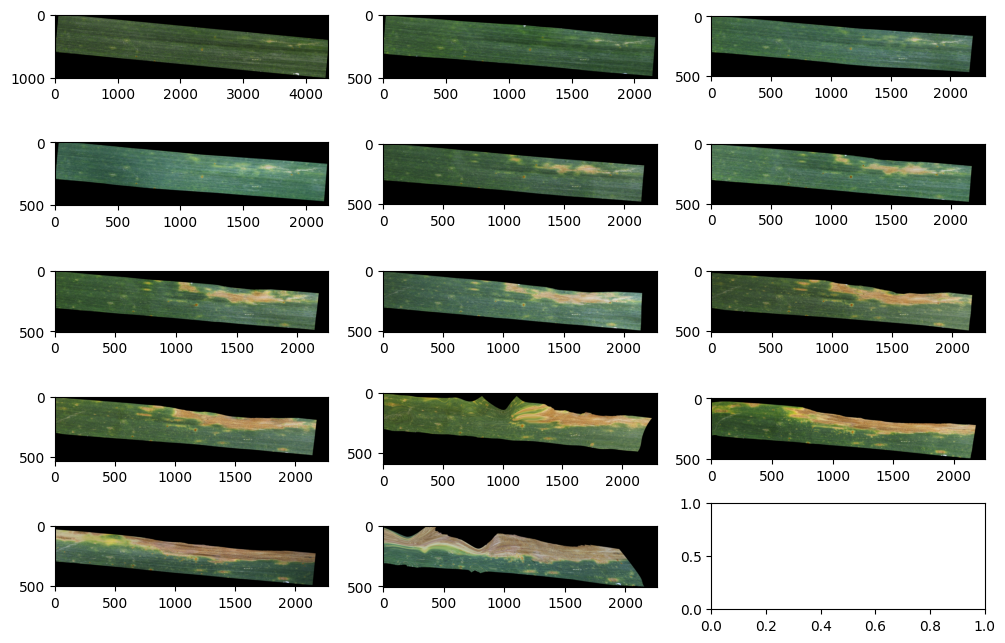

In [19]:
fig, axs = plt.subplots(5, 3, figsize=(12,8))
axs[0,0].imshow(K.tensor_to_image(imgs[0]))
axs[0,1].imshow(K.tensor_to_image(imgs[1]))
axs[0,2].imshow(K.tensor_to_image(imgs[2]))

axs[1,0].imshow(K.tensor_to_image(imgs[3]))
axs[1,1].imshow(K.tensor_to_image(imgs[4]))
axs[1,2].imshow(K.tensor_to_image(imgs[5]))

axs[2,0].imshow(K.tensor_to_image(imgs[6]))
axs[2,1].imshow(K.tensor_to_image(imgs[7]))
axs[2,2].imshow(K.tensor_to_image(imgs[8]))

axs[3,0].imshow(K.tensor_to_image(imgs[9]))
axs[3,1].imshow(K.tensor_to_image(imgs[10]))
axs[3,2].imshow(K.tensor_to_image(imgs[11]))

axs[4,0].imshow(K.tensor_to_image(imgs[12]))
axs[4,1].imshow(K.tensor_to_image(imgs[13]))
# axs[4,2].imshow(K.tensor_to_image(imgs[14]))
plt.show()

## Purely Sequential

### Batch Size Matching

In [3]:
i0 = 0
i1 = 5
i2 = 7
img0, mask0 = fetch_image_mask_pair(leaf, i0, img_scale="roi", erase_markers=True, pre_rotate=False)
img1, mask1 = fetch_image_mask_pair(leaf, i1, img_scale="roi", erase_markers=True, pre_rotate=False)
img2, mask2 = fetch_image_mask_pair(leaf, i2, img_scale="roi", erase_markers=True, pre_rotate=False)

imgs = [img0, img1, img2]
masks = [mask0, mask1, mask2]

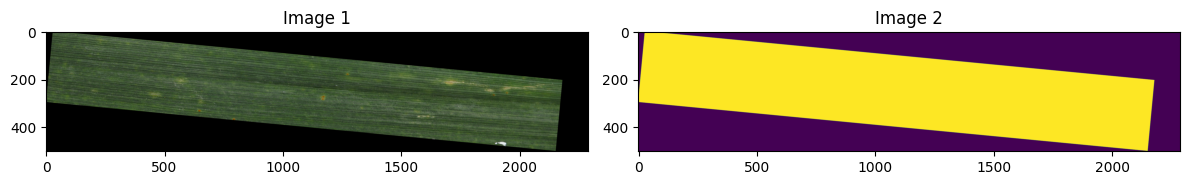

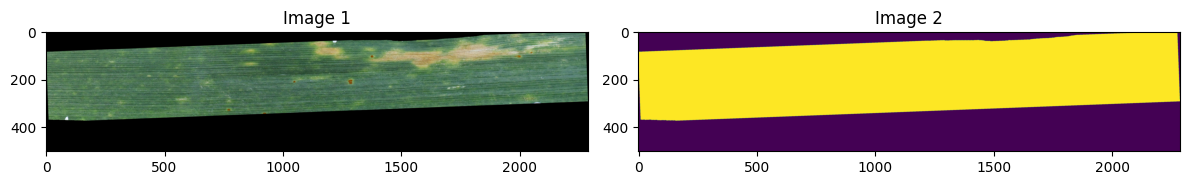

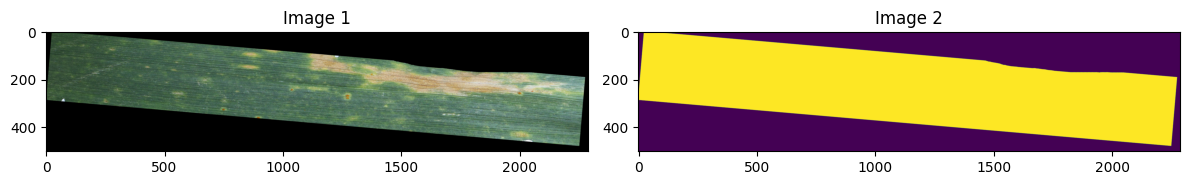

In [4]:
padded_imgs, padded_masks = match_sizes_resize_batch(imgs, masks)
for i in range(len(padded_imgs)):
    _ = plot_image_pair(padded_imgs[i], padded_masks[i])

### Composing TPS Transforms

In [20]:
# register
img1_w, mask1_w, tps_01 = register_loftr_tps(imgs[0], imgs[1], mask_moving=masks[1], verbose=True, plot_loftr_matches=False, return_tps=True)
img2_w, mask2_w, tps_12 = register_loftr_tps(imgs[1], imgs[2], mask_moving=masks[2], verbose=True, plot_loftr_matches=False, return_tps=True)
 

Total matches: 5127
Matches with Confidence > 0.5: 3495
Inliers: 3043 (59.35%)
Setting threshold..
Threshold set to 0.9725122093056
Estimating TPS transform...
Transforming moving image...
Transforming moving image...
Total matches: 6687
Matches with Confidence > 0.5: 4791
Inliers: 3298 (49.32%)
Setting threshold..
Threshold set to 0.9887410009315738
Estimating TPS transform...
Transforming moving image...
Transforming moving image...


In [21]:
def compose_tps(transforms):
    def composed(coords):
        for t in transforms:
            coords = t(coords)
        return coords
    return composed

In [22]:
# order matters!
# [T_k_to_k-1, ..., T_1_to_0]
tps_chain = [tps_12, tps_01]
coord_map = compose_tps(tps_chain)


Transforming moving image...


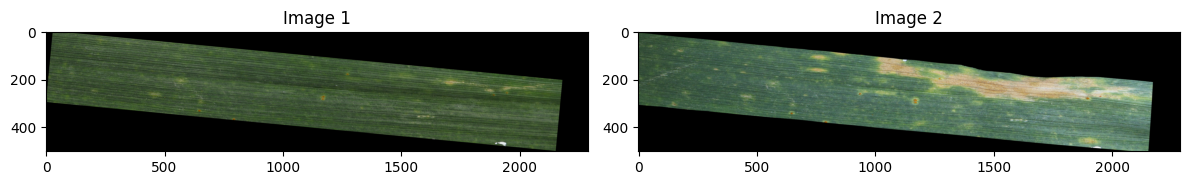

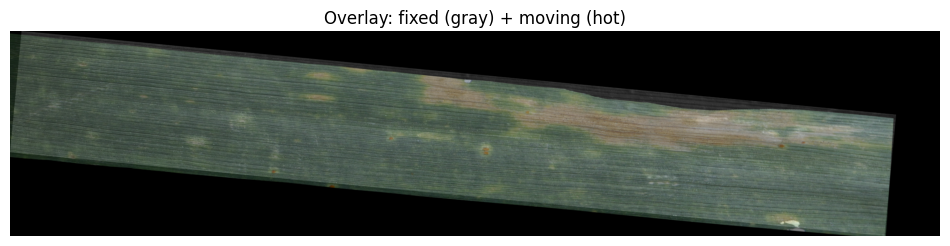

In [23]:
out = warp_tps(imgs[2], coord_map, verbose=True)
_ = plot_image_pair(imgs[0], out)
_ = plot_overlay(imgs[0], out)

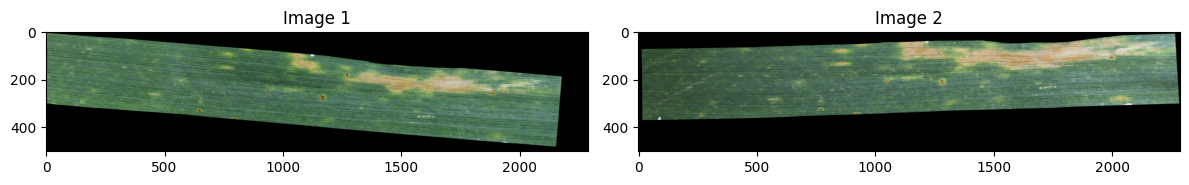

In [24]:
_ = plot_image_pair(img1_w, img2_w)

### All together